# Bayesian Naive Bayes

### Spring 2022 - Course Project

### Authors: Marc Taberner, Otis Carpay

In this notebook we will first study the standard frequentist approach to the Naive Bayes Classifier. To do so, we define a base class for the classifier and subclass it for the Bernoulli, Multinomial, and Gaussian models. We test these classifiers on two text classification datasets and two continuous numerical datasets.

The second part of the notebook treats a Bayesian approach. We will compare the frequentist approach with analytical Bayesian implementations of the Bernoulli and the Multinomial event model, and Stan implementation of all models.

## Frequentist approach

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multinomial, norm, bernoulli
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

### Class for Naive Bayes Classifier:

Here we define the base class, which will be subclassed for the specific event models. These event models will implement a `compute_params` function to compute the MLE estimators for the parameters (sufficient statistics) of the distributions, and a `compute_probabilities` function to compute the probabilities $P(X_{j} = x_{j}|C = i)$ for a given subset of the data of class $i$.

The `fit` function calls the `compute_parameters` for the subset of data for every class and computes the class_probabilites $P(C = i)$.
The function `posteriors` (following the term classically used for Naive Bayes and not referring to a Bayesian concept in this case) calculates
$$g_{i}(x) = \prod_{j= 1}^{n}P(X_{j} = x_{j}|C = i) P(C = i)$$
 and `predict` calculates 
$$\argmax g_{i}(x).$$

In [2]:
class NaiveBayes:
  def compute_params(self, X):
    # to be defined in a subclass
    # function to compute the distribution parameters
    # should return an list of parameter arrays of shape (classes, features)
    return [[]]

  def compute_probabilities(self, X, params):
    # to be defined in a subclass
    # function to compute the probabilities from the parameters
    pass

  def fit(self, X, y):
    # retrieve the number of samples and features from X
    self.n_samples, self.n_features = X.shape

    # collect the individual classes, and record their counts to compute priors
    self.classes, counts = np.unique(y, return_counts=True)

    # compute the parameters for every class - we transpose the array so that
    # the final dimensions are (parameters, classes, features)
    self.params = np.array(
      [self.compute_params(X[c==y]) for c in self.classes]
    ).transpose(1, 0, 2)

    # compute the class probabilities from the counts
    self.class_probs = np.log(counts/self.n_samples)

    return self

  def posteriors(self, X):
    # reshape X to fit the array dimensions (samples, classes, features)
    X = np.reshape(X, (-1, 1, self.n_features))

    # compute the probabilities P(X_j = x_j | C = i)
    probs = self.compute_probabilities(X, *self.params[:,np.newaxis])

    # finally compute the posteriors by summing all log probs
    return probs.sum(axis=2) + self.class_probs[np.newaxis]

  def predict(self, X):
    # predict the class with the maximum probability
    return self.classes[np.argmax(self.posteriors(X), axis=1)]

#### Bernoulli model

First we define the Bernoulli model. We include a smoothing parameters $\alpha$ and set it to a small $10^{-10}$ by default to avoid computational problems. We clip the data to a maximum of 1 so we can apply the classifier to a multinomial dataset without any extra work.

In [3]:
class BernoulliNB(NaiveBayes):
  def __init__(self, alpha=1e-10):
    self.alpha = alpha

  def compute_params(self, X):
    # the MLE estimations are easily calculated by taking the mean
    return [X.clip(max=1).mean(axis=0) + self.alpha]
  
  def compute_probabilities(self, X, phi):
    return bernoulli.logpmf(X.clip(max=1), phi)

#### Multinomial model

Like the Bernoulli model, we include a smoothing parameter

In [4]:
class MultinomialNB(NaiveBayes):
  def __init__(self, alpha=1e-10):
    self.alpha = alpha

  def compute_params(self, X):
    counts = X.sum(axis=0) + self.alpha
    return [counts/counts.sum()]

  def compute_probabilities(self, X, phi):
    # we need to add a new axis to conform to the shape expected by
    # the posteriors function: the feature axis is of size 1 since
    # the distribution gives the probability of a whole sample
    return multinomial.logpmf(X, X.sum(axis=2), phi)[...,np.newaxis]

### Gaussian model

Finally, the Gaussian model perhaps has the most straightforward code

In [5]:
class GaussianNB(NaiveBayes):
  def compute_params(self, X):
    # return the mean and the standard deviation of the features
    return [X.mean(axis=0), X.std(axis=0)]

  def compute_probabilities(self, X, mean, sd):
    return norm.logpdf(X, mean, sd)

### Experiments

Since we will do this many times, we define a function to fit a classifier and print its train and test accuracies automatically

In [6]:
def evaluate_clf(clf, xtrain, xtest, ytrain, ytest):
  # fit the classifier with the training data
  clf.fit(xtrain, ytrain)
  # make the predictions for both sets
  y_pred_test = clf.predict(xtest)
  y_pred_train = clf.predict(xtrain)
  # evaluate and print the accuracies
  print(f"The train error is: {(y_pred_train == ytrain).mean():.3f}")
  print(f"The test error is: {(y_pred_test == ytest).mean():.3f}")

#### Spam classification

Given an e-mail message, determine wheather such message is Spam or Ham, text classification task:

In [7]:
data = pd.read_csv("data/spam.csv", encoding='latin-1')
data = data[["class", "message"]]
data

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


We transform the documents to multinomial points with the sklearn `CountVectorizer` class. It transforms the data to vectors with the number of occurrences for each word. We set it to excludes words from a list of common words called 'stop words', and limit the words to the 1000 top words for computational speed. In our tests, the effect on accuracy was negligible.

In [8]:
x = np.array(data["message"])
y = np.array(data["class"])

cv = CountVectorizer(stop_words='english', max_features=1000)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

xtrain = cv.fit_transform(xtrain).toarray()
xtest = cv.transform(xtest).toarray()

Note that we have the value counts with valus up to 18 occurrences, we can work then with Bernoulli, Multinomial and Gaussian Naive Bayes. We expect that multinomial will be the most efficient, since it most accurately expresses the data in this form:

In [9]:
np.unique(xtrain)

array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 15, 18])

##### Using Bernoulli Naive Bayes

For the evaluation of the models, we chose the best alpha (smoothing parameter) value from some manual exploration. One thing to observe is that this is different for different datasets, but within a dataset there is a quite clear curve without much noise.

In [10]:
evaluate_clf(BernoulliNB(alpha=1e-4), xtrain, xtest, ytrain, ytest)

The train error is: 0.990
The test error is: 0.984


##### Using Multinomial Naive Bayes:

In [11]:
evaluate_clf(MultinomialNB(alpha=2), xtrain, xtest, ytrain, ytest)

The train error is: 0.985
The test error is: 0.983


We find that for their own optimal alpha values, the two models have very similar results

##### Using Gaussian Naive Bayes

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


The train error is: 0.134
The test error is: 0.135


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


The train error is: 0.866
The test error is: 0.865


#### BBC Article Classification

This dataset is a collection of BBC articles annotated with the type of the article

In [14]:
data = pd.read_csv("data/articles.csv")
data

,news,type
0,China had role in Yukos split-up\n \n China le...,business
1,Oil rebounds from weather effect\n \n Oil pric...,business
2,Indonesia 'declines debt freeze'\n \n Indonesi...,business
3,$1m payoff for former Shell boss\n \n Shell is...,business
4,US bank in $515m SEC settlement\n \n Five Bank...,business
...,...,...
2220,Microsoft launches its own search\n \n Microso...,tech
2221,Warnings about junk mail deluge\n \n The amoun...,tech
2222,Microsoft gets the blogging bug\n \n Software ...,tech
2223,Gamers snap up new Sony PSP\n \n Gamers have b...,tech


We have the following five article types:

In [15]:
data['type'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

We transform the dataset in the same way as the previous dataset

In [16]:
x = np.array(data["news"])
y = np.array(data["type"])

cv = CountVectorizer(stop_words='english', max_features=1000) # count the amout of occurrences for each word
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)
xtrain = cv.fit_transform(xtrain).toarray()
xtest = cv.transform(xtest).toarray()

##### Using Bernoulli Naive Bayes:

In [17]:
evaluate_clf(BernoulliNB(alpha=1e-7), xtrain, xtest, ytrain, ytest)

The train error is: 0.976
The test error is: 0.937


##### Using Multinomial Naive Bayes:

In [18]:
evaluate_clf(MultinomialNB(alpha=2), xtrain, xtest, ytrain, ytest)

The train error is: 0.975
The test error is: 0.951


In this case, the multinomial model performs marginally better. Again, the alpha value plays quite a big rule. It might have to do with the fact that repetition of certain words is more strongly correlated with the article type, which is modeled by the multinomial distribution but not the Bernoulli distribution.

##### Using Gaussian Naive Bayes

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/otis/Documents/uni/2/Bayes/Project/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1945: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


The train error is: 0.222
The test error is: 0.258


#### Raisin dataset

The raisin dataset was from a study of machine vision systems in order to distinguish between two distinct varieties of raisins, Kecimen and Besni, a total of 900 pices of raisin were obtained and distinct metric values were recorded and included in the dataset. 

In [20]:
df = pd.read_csv('data/Raisin_Dataset.csv')
x = np.array(df.drop("Class", axis=1))
y = np.array(df["Class"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

In [21]:
df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


Naturally given that the data presented is continous, of the studied models we can only apply the Gaussian Naive Bayes. Let's observe the yielding results:

In [22]:
scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

The train error is: 0.838
The test error is: 0.839


At a later point in the report, we will compare this accuracy with the Stan implementation

#### Iris Dataset

This dataset is similar to the Raisin dataset, this set of data containd 50 distinct samples of 3 distinct Iris plants, Iris setosa, Iris viginica and Iris Versicolor. 4  distinct features were recorded for each plant, we would want to be able to tell apart each of this type of Iris just with this given 4 features. 

In [23]:
df = pd.read_csv('data/Iris.csv').drop('Id', axis=1)
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


As in the Raisin Dataset, data is continous, and hence, the only course of action would be to approach it using a Gaussian Naive Bayes.

In [24]:
x = np.array(df.drop("Species", axis=1))
y = np.array(df["Species"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

In [25]:
scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

The train error is: 0.950
The test error is: 1.000


## Bayesian approach

In this part we will take a Bayesian approach to the Naive Bayes classifier. That is, we define prior distributions over the parameters of the classifier. We define first analytical formulations of the Bayesian version of the Bernoulli and Multinomial models. Then we obtain the parameters from the data via probabilistic inference with Stan.

### Analytical

We don't have to do much to adapt the classes so that they implement a Bayesian approach. We change the `compute_params` function to take an estimator from the posterior distribution, which is defined by the prior parameters together with the data. Instead of the MAP, we take the mean of the posterior distribution since we will do the same for the Stan models

In [26]:
from scipy.stats import beta, dirichlet

#### Bernoulli

For the Bermoulli model, the conjugate prior is a beta distribution with parameters $\alpha$ and $\beta$

In [27]:
class BayesBernoulliNB(BernoulliNB):
  def __init__(self, alpha=1, beta=1):
    # set the parameters for the prior beta distribution
    self.a = alpha,
    self.b = beta

  def compute_params(self, X):
    X = X.clip(max=1)
    return [beta.mean(self.a + X.sum(axis=0), self.b + len(X) - X.sum(axis=0))]

#### Multinomial

For the multinomial model, the conjugate prior is a dirichlet distribution with parameter $\alpha$

In [28]:
class BayesMultinomialNB(MultinomialNB):
  def __init__(self, alpha=[1]):
    # set the parameters for the prior beta distribution
    self.a = np.array(alpha)

  def compute_params(self, X):
    return [dirichlet.mean(self.a + X.sum(axis=0))]

### Stan Implementation

In [38]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio
import stan

Now we define the stan models. The Stan code is located in the `.stan` files in this folder. We can subclass the `NaiveBayes` base class and change the fit function to sample the stan model. Then we change the parameters to the means of distributions estimated by Stan. First we define a base class with shared code for the `fit` function and then perform necessary transformations in the subclasses.

In [39]:
class StanNB(NaiveBayes):
  def __init__(self, model_path, random_state=None):
    self.seed = random_state

    # read the model from its respective file, defined in a subclass
    with open(model_path) as f:
      self.stan_model = f.read()

  def fit(self, X, y, data, param_names):
    self.stan_data = data           # data object
    self.param_names = param_names  # parameter names we have to retrieve from the model

    posterior = stan.build(self.stan_model, data=self.stan_data, random_seed=self.seed)
    self.stan_fit = posterior.sample(num_chains=4, num_samples=1000)

    # call the fit function of the base class so that the necessary attributes
    super().fit(X, y)
    
    # change the class probabilities and parameters to the mean of the distributions
    # estimated by stan
    self.class_probs = self.stan_fit['theta'].mean(axis=-1)
    self.params = np.array(
      [self.stan_fit[param].mean(axis=-1) for param in param_names]
    )

    return self

#### Bernoulli

The Bernoulli model is rather straightforward

In [40]:
class StanBernoulliNB(StanNB):
  def __init__(self, *, class_prior, param_prior, random_state=None):
    self.alpha = class_prior  # parameter for the dirichlet distribution
    self.beta = param_prior   # two parameters for the beta distribution
    super().__init__(model_path='model_bernoulli.stan', random_state=random_state)

  def compute_probabilities(self, X, phi):
    return BernoulliNB.compute_probabilities(self, X, phi)
  
  def fit(self, X, y):
    # y_int is the y vector but with integers for each class,
    # since this is the type that we need to pass to stan
    classes, y_int = np.unique(y, return_inverse=True)

    data = {
      'C': len(classes),    # num categories
      'K': X.shape[1],      # num features
      'N': X.shape[0],      # num samples
      'y': y_int + 1,       # category of sample n
      'x': X.clip(max=1),   # sample n
      'alpha': self.alpha,  # class prior
      'beta': self.beta     # feature prior
    }

    return super().fit(X, y, data, ['phi'])

#### Multinomial

The code for the multinomial model is adapted from the Stan User's Guide. The data is passed to the model in following manner:

|n                       | w[n]         | doc[n]    |
|------------------------|--------------|-----------|
|1                       | $w_{1,1}$    | 1         |
|2                       | $w_{1,2}$    | 1         |
|$\vdots$                | $\vdots$     | $\vdots$  |
|$N_1$                   | $w_{1,N[1]}$ | 1         |
|$N_1 + 1$               | $w_{2,1}$    | 2         |
|$N_1 + 2$               | $w_{2,2}$    | 2         |
|$\vdots$                | $\vdots$     | $\vdots$  |
|$N_1 + N_2$             | $w_{2,N[2]}$ | 2         |
|$N_1 + N_2 + 1$         | $w_{3,1}$    | 3         |
|$\vdots$                | $ \vdots$    | $ \vdots$ |
|$N = \sum_{m=1}^M N_m$  | $w_{M,N[M]}$ | $M$       |

Here, $N$ is the total number of words in all documents, and `w[n]` and `doc[n]` are the specific word (a number) and document number for word `n`, where `n=1` corresponds to the first word in the first document. Although this format conveys word order, this is not used by the Stan model. In fact, we will pass the words in the wrong order, just repeating a certain word the number of times indicated in the vector produced by `CountVectorizer`.

In [41]:
class StanMultinomialNB(StanNB):
  def __init__(self, *, class_prior, param_prior, random_state=None):
    self.alpha = class_prior  # dirichlet distribution
    self.beta = param_prior   # dirichlet distributions for every class
    super().__init__(model_path='model_multinomial.stan', random_state=random_state)

  def compute_probabilities(self, X, phi):
    return MultinomialNB.compute_probabilities(self, X, phi)
  
  def fit(self, X, y):
    classes, y_int = np.unique(y, return_inverse=True)

    # we get the indexes of al nonzero items, where the row refers to the
    # document number and the column to the specific word
    idx = X.nonzero()
    # vector of counts to repeat the items of the above vectors the appropriate
    # number of times
    values = X[idx]

    word_ids = np.repeat(idx[1],values)
    doc_ids = np.repeat(idx[0],values)

    data = {
      'K': len(classes),    # num classes
      'V': X.shape[1],      # num words
      'M': X.shape[0],      # num docs
      'N': len(word_ids),   # total word instances
      'z': y_int + 1,       # class for doc m
      'w': word_ids + 1,    # word n
      'doc': doc_ids + 1,   # doc ID for word n
      'alpha': self.alpha,  # class prior
      'beta': self.beta     # feature prior
    }

    return super().fit(X, y, data, ['phi'])

#### Gaussian

The gaussian model is also straightforward

In [42]:
class StanGaussianNB(StanNB):
  def __init__(self, *, class_prior, mu_prior, sigma_prior, random_state=None):
    self.alpha = class_prior                         # dirichlet distribution
    self.mu_mu, self.mu_sigma = mu_prior             # normal distribution of the means
    self.sigma_alpha, self.sigma_beta = sigma_prior  # inverse gamma distribution of the variances
    super().__init__(model_path='model_gaussian.stan', random_state=random_state)

  def compute_probabilities(self, X, mean, sd):
    return GaussianNB.compute_probabilities(self, X, mean, sd)
  
  def fit(self, X, y):
    classes, y_int = np.unique(y, return_inverse=True)

    data = {
      'C': len(classes),                # num classes
      'K': X.shape[1],                  # num features
      'N': X.shape[0],                  # num samples
      'y': y_int + 1,                   # class of sample n
      'x': X,                           # sample n
      'alpha': self.alpha,              # class prior
      'mu_mu': self.mu_mu,              # feature mean prior
      'mu_sigma': self.mu_sigma,        # feature mean prior
      'sigma_alpha': self.sigma_alpha,  # feature sd prior
      'sigma_beta': self.sigma_beta     # feature sd prior
    }

    return super().fit(X, y, data, ['mu', 'sigma'])

### Experiments

Now we apply both the Stan and the analytical models to the datasets. In doing this, we will limit the training set to 100 sample of 100 features, to avoid excessive computation time in Stan.

#### Spam dataset

In [43]:
data = pd.read_csv("data/spam.csv", encoding='latin-1')
x = np.array(data["message"])
y = np.array(data["class"])

cv = CountVectorizer(stop_words='english', max_features=100)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=100, random_state=42, shuffle = True)

xtrain = cv.fit_transform(xtrain).toarray()
xtest = cv.transform(xtest).toarray()

##### Bernoulli model

In [44]:
evaluate_clf(BernoulliNB(alpha=1e-10), xtrain, xtest, ytrain, ytest)

The train error is: 0.980
The test error is: 0.907


In [45]:
# here, the alpha and beta parameters are the shape parameters of the prior beta distribution
evaluate_clf(BayesBernoulliNB(alpha=0.1, beta=0.1), xtrain, xtest, ytrain, ytest)

The train error is: 0.980
The test error is: 0.910


We find that the Bayesian model performs slightly better than the frequentist model, but there is not enough difference to make any statements. What is interesting is that the most succesful parameters are those of a U-shaped, bimodal prior distribution. It is difficult to say why this is

In [46]:
evaluate_clf(
  StanBernoulliNB(
    class_prior=[0.1,0.1],                          # dirichlet distribution
    param_prior=np.full((xtrain.shape[1], 2), 0.1), # beta distributions over the features
    random_state=42),
  xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling

The train error is: 0.970
The test error is: 0.906


Our Stan model performs similarly to the analytical model!

##### Multinomial model

In [47]:
evaluate_clf(MultinomialNB(alpha=0.1), xtrain, xtest, ytrain, ytest)

The train error is: 0.980
The test error is: 0.912


In [48]:
# here, the alpha parameter refers to the shape parameter of the dirichlet prior
evaluate_clf(BayesMultinomialNB(alpha=[0.1]), xtrain, xtest, ytrain, ytest)

The train error is: 0.980
The test error is: 0.912


The results are the same!

In [49]:
evaluate_clf(
  StanMultinomialNB(
    class_prior=[1, 1],
    param_prior=np.full(xtrain.shape[1], 0.1),
    random_state=42),
  xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling

The train error is: 0.950
The test error is: 0.874


This time the results are a little worse

#### Article dataset

Define the dataset and limit it to 100 words and 100 sample

In [74]:
data = pd.read_csv("data/articles.csv")
x = np.array(data["news"])
y = np.array(data["type"])

cv = CountVectorizer(stop_words='english', max_features=100)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=100, random_state=42, shuffle=True)

xtrain = cv.fit_transform(xtrain).toarray()
xtest = cv.transform(xtest).toarray()

In [75]:
num_classes = len(np.unique(y))

##### Bernoulli model

In [76]:
evaluate_clf(BernoulliNB(alpha=0.01), xtrain, xtest, ytrain, ytest)

The train error is: 0.940
The test error is: 0.816


In [77]:
evaluate_clf(BayesBernoulliNB(alpha=0.5, beta=0.5), xtrain, xtest, ytrain, ytest)

The train error is: 0.930
The test error is: 0.816


Again we find similar performace for the frequentist and the Bayes models, and the curious fact that the most successful prior is again a bimodal one.

In [78]:
evaluate_clf(
  StanBernoulliNB(
    class_prior=np.full(num_classes, 0.1),
    param_prior=np.full((xtrain.shape[1], 2), 0.1),
    random_state=42),
  xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.002516 seconds
  1000 transitions using 10 leapfrog steps per transition would take 25.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002418 seconds
  1000 transitions using 10 leapfrog steps per transition would take 24.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002634 seconds
  1000 transitions using 10 leapfrog steps per transition would take 26.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002564 seconds
  1000 transitions using 10 leapfrog steps per transition would take 25.64 seconds.
  Adjust your expectations accordingly!


The train error is: 0.960
The test error is: 0.816


The Stan model shows very similar behaviour

##### Multinomial model

In [79]:
evaluate_clf(MultinomialNB(alpha=0.5), xtrain, xtest, ytrain, ytest)

The train error is: 0.940
The test error is: 0.818


In [80]:
evaluate_clf(BayesMultinomialNB(alpha=[0.5]), xtrain, xtest, ytrain, ytest)

The train error is: 0.940
The test error is: 0.818


In [81]:
clf = StanMultinomialNB(
    class_prior=np.full(num_classes, 1),
    param_prior=np.full(xtrain.shape[1], 0.5),
    random_state=42)

evaluate_clf(clf, xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.003349 seconds
  1000 transitions using 10 leapfrog steps per transition would take 33.49 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002261 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.003418 seconds
  1000 transitions using 10 leapfrog steps per transition would take 34.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002226 seconds
  1000 transitions using 10 leapfrog steps per transition would take 22.26 seconds.
  Adjust your expectations accordingly!


The train error is: 0.950
The test error is: 0.822


Here, the Stan model performs better, but with negligible difference

##### Investigating parameters

Before we continue, we will look a little more into the output of the Stan model, and look at the distribution of some of the parameters

In [82]:
# define an ordering so that we can sort the vectors with words
# and positions obtained from the vocabulary variable of the
# CountVectorizer to find the positions of the most common words
order = np.argsort(-xtrain.sum(axis=0))
words = np.array(list(cv.vocabulary_.keys()))[order]
positions = np.array(list(cv.vocabulary_.values()))[order]

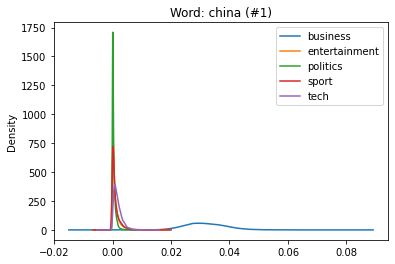

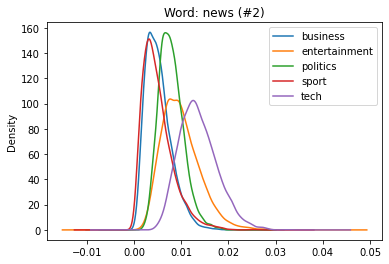

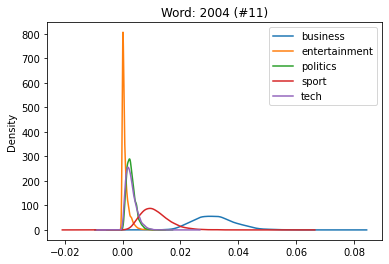

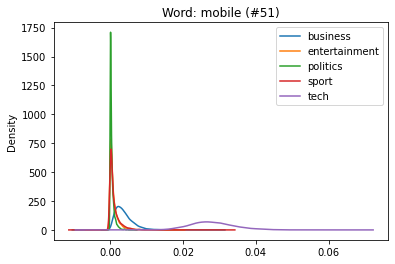

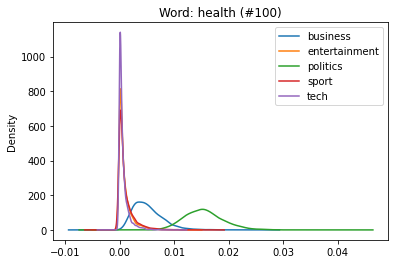

In [83]:
# obtain a dataframe from the fit
df = clf.stan_fit.to_frame()

# we will look into the distribution of the first, the second,
# the tenth, the 51st, and the 100th most common words
for i in [0,1,10,50,99]:
  ax = df[[f'phi.{c}.{positions[i]+1}' for c in range(1,6)]].plot(
    kind='density',
    title=f'Word: {words[i]} (#{i+1})')
  ax.legend(np.unique(ytrain))

The above output seems to roughly coincide with what we would expect of the distributions of these words. Interestingly China seems to be mentioned only in business articles, but so many times that it is the most common word. For other words, we get the expected tendency of less common words being increasingly specific to certain types of articles

#### Raisin dataset

Finally, we apply the Stan implementation of the Gaussian model to the continuous datasets

In [84]:
df = pd.read_csv('data/Raisin_Dataset.csv')
x = np.array(df.drop("Class", axis=1))
y = np.array(df["Class"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [85]:
evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

The train error is: 0.838
The test error is: 0.839


In [86]:
evaluate_clf(
  StanGaussianNB(
    class_prior=[1,1],
    mu_prior=[0,5],
    sigma_prior=[1,1],
    random_state=42),
  xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000714 seconds
  1000 transitions using 10 leapfrog steps per transition would take 7.14 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/httpstan_viy8kflv/model_kifmkw5d.stan', line 49, column 6 to column 52)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter 

The train error is: 0.835
The test error is: 0.833


We find similar performance

#### Iris dataset

In [87]:
df = pd.read_csv('data/Iris.csv')
x = np.array(df.drop("Species", axis=1))
y = np.array(df["Species"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

scaler = StandardScaler().fit(xtrain) #to standarize features to a zero mean and 1 variance!
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [88]:
evaluate_clf(GaussianNB(), xtrain, xtest, ytrain, ytest)

The train error is: 0.992
The test error is: 1.000


In [89]:
evaluate_clf(
  StanGaussianNB(
    class_prior=np.full(len(np.unique(y)), 1),
    mu_prior=[0,5],
    sigma_prior=[1,1],
    random_state=42),
  xtrain, xtest, ytrain, ytest)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000141 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.41 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/bv/ghbrqbgj6g9crhy3384p3ggw0000gn/T/httpstan_viy8kflv/model_kifmkw5d.stan', line 49, column 6 to column 52)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
  Adjust your expectations a

The train error is: 0.992
The test error is: 1.000


In this case, the accuracies are equal